In [1]:
import numpy as np
import pandas as pd
import os 
import glob

import math
import json
import scipy
import scipy.stats
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
import pickle as pckl
from PIL import Image
import seaborn as sns

from model_analysis_folders import all_model_info
import urllib.request, json
from scipy.io import loadmat

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 6})



In [2]:
models_to_evaluate = ["kell2018","cochresnet50",
                      "cochresnet50_l2_1_robust_waveform", "cochresnet50_l2_p5_robust_waveform", "cochresnet50_linf_p002_robust_waveform",
                      "cochresnet50_l2_1_random_step_waveform", "cochresnet50_linf_p002_random_step_waveform",
                      "kell2018_l2_1_robust_waveform", "kell2018_linf_p002_robust_waveform",
                      "kell2018_l2_1_random_step_waveform", "kell2018_linf_p002_random_step_waveform",
                      "cochresnet50_l2_1_robust_cochleagram", "cochresnet50_l2_p5_robust_cochleagram",
                      "cochresnet50_l2_1_random_step_cochleagram",
                      "kell2018_l2_1_robust_cochleagram", "kell2018_l2_p5_robust_cochleagram",
                      "kell2018_l2_1_random_step_cochleagram",
                     ]

# Set the colors for the models we are measuring. 
model_cmap = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

plot_color_idx = [0,3,
                10,11,12,
                10,12,
                1,2,
                1,2,
                10,11,
                10,
                1,2,
                1,
                ]


assert (len(np.unique(plot_color_idx)) <= len(model_cmap)), 'Not enough colors to plot all of the networks!'
model_cmap_dict = {m:model_cmap[plot_color_idx[m_idx]] for m_idx, m in enumerate(models_to_evaluate)}

# Set the line styles for the models we are measuring

plot_style = ['-','-',
              '-','-','-',
              ':',':',
              '-','-',
              ':',':',
              '--', '--',
              '-.', 
              '--', '--',
              '-.',]

model_style_dict = {m:plot_style[m_idx] for m_idx, m in enumerate(models_to_evaluate)}


plot_num = [0,0,
            1,1,1,
            1,1,
            2,2,
            2,2,
            3,3,
            3,
            4,4,
            4] 

network_network_folder = 'network_network_evaluations'

models_by_type = {'kell2018':'standard',
              'cochresnet50':'standard',
              'cochresnet50_l2_1_robust_waveform':'adv_trained_wav',
              'cochresnet50_l2_p5_robust_waveform':'adv_trained_wav',
              'cochresnet50_linf_p002_robust_waveform':'adv_trained_wav',                 
              "cochresnet50_l2_1_random_step_waveform":'rand_trained_wav',
              "cochresnet50_linf_p002_random_step_waveform":'rand_trained_wav',                  
              'kell2018_l2_1_robust_waveform':'adv_trained_wav',
              'kell2018_linf_p002_robust_waveform':'adv_trained_wav',                  
              "kell2018_l2_1_random_step_waveform":'rand_trained_wav',
              "kell2018_linf_p002_random_step_waveform":'rand_trained_wav',                  
              'cochresnet50_l2_1_robust_cochleagram':'adv_trained_coch',
              'cochresnet50_l2_p5_robust_cochleagram':'adv_trained_coch',                  
              'cochresnet50_l2_1_random_step_cochleagram':'rand_trained_coch',
              'kell2018_l2_1_robust_cochleagram':'adv_trained_coch',
              'kell2018_l2_p5_robust_cochleagram':'adv_trained_coch',                  
              'kell2018_l2_1_random_step_cochleagram':'rand_trained_coch',
             }

model_types = ['standard','adv_trained_wav','adv_trained_coch','rand_trained_wav','rand_trained_coch']


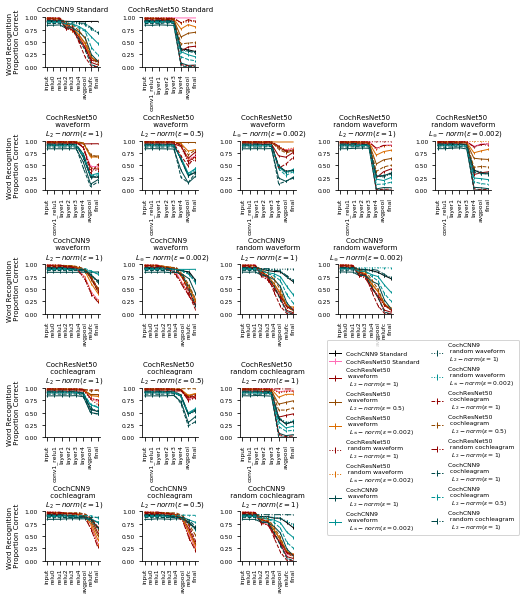

In [3]:
# Raw data -- all models. 16 way predictions because that is what the humans did (and this is how we validated the metamers)

current_row = 0
subplot_idx=0
num_rows = 5
num_columns = 5
fig, axs = plt.subplots(num_rows, num_columns, figsize=(2*4,2*num_rows),
                        gridspec_kw={'hspace': 1.5, 'wspace': 0.75})

all_other_nets_evals = {}

# These will group together the MEASUREMENTS from a given model type. 
all_other_nets_evals_by_type = {}

for met_mod_idx, metamer_model in enumerate(models_to_evaluate): 
    all_other_nets_evals[metamer_model] = {}
    all_other_nets_evals_by_type[metamer_model] = {}
    metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
    model_name = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['paper_name']
    for layer in metamer_model_layers:
        all_other_nets_evals[metamer_model][layer] = []
        all_other_nets_evals_by_type[metamer_model][layer] = {m_type:[] for m_type in model_types}
    for measured_model in models_to_evaluate:
        measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[measured_model]
        pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
        eval_pckl = pckl.load(open(pckl_path, 'rb'))
        # Store the data here. 
        for layer in metamer_model_layers:
            all_other_nets_evals[metamer_model][layer].append(eval_pckl['average_correct'][layer])
            all_other_nets_evals_by_type[metamer_model][layer][models_by_type[measured_model]].append(eval_pckl['average_correct'][layer])
        axs[current_row, subplot_idx].errorbar(range(len(metamer_model_layers)), 
                 [eval_pckl['average_correct'][layer] for layer in metamer_model_layers],
                     yerr=[eval_pckl['bootstrap_sem'][layer] for layer in metamer_model_layers],
                 color=model_cmap_dict[measured_model],
                 linewidth=1,
                 ls=model_style_dict[measured_model])
    axs[current_row, subplot_idx].set_title(model_name, fontsize=7)
    axs[current_row, subplot_idx].set_ylim([0,1])
    if subplot_idx==0:
        axs[current_row, subplot_idx].set_ylabel('Word Recognition \n Proportion Correct', fontsize=7)
    if (current_row==3) and (subplot_idx==2):
        axs[current_row, subplot_idx].legend([all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[name]['paper_name'] for name in models_to_evaluate], loc='center left', bbox_to_anchor=(1.5, 0), fontsize=6, ncol=2)
    axs[current_row, subplot_idx].set_xticks(range(len(metamer_model_layers)))
    axs[current_row, subplot_idx].set_xticklabels(labels=[layer.split('_fake_relu')[0].split('_fakerelu')[0].split('_after_preproc')[0] for layer in metamer_model_layers], rotation=90, fontsize=6)
    # Hide the right and top spines
    axs[current_row, subplot_idx].spines['right'].set_visible(False)
    axs[current_row, subplot_idx].spines['top'].set_visible(False)


    try:
        if plot_num[met_mod_idx+1]!=current_row:
            for k in range(subplot_idx+1,num_columns):
                axs[current_row,k].set_axis_off()
            current_row+=1
            subplot_idx=0
        else:
            subplot_idx+=1
    except IndexError:
        for k in range(subplot_idx+1,num_columns):
            axs[current_row,k].set_axis_off()
        continue
        
plt.savefig('audio_model_model_comparisons_all_models.pdf')


In [4]:
def responses_network_by_layer_mat(all_subjects_answers, model_layers, conditions, experiment_params):
    network_response_dict = {}    
    condition_idx = list(conditions).index('Human  ')
    
    for l_idx, layer in enumerate(model_layers):
        network_response_dict[layer.strip()] = list(all_subjects_answers[:,l_idx,condition_idx])
        
    return network_response_dict

def combined_experiment_response_dictionaries(all_dicts):
    # all_dicts -- list of dictionaries output from respones_network_by_layer
    combined_experiment_dict = {}
    for experiment in all_dicts:
        for model in experiment.keys():
            if model not in list(combined_experiment_dict.keys()):
                combined_experiment_dict[model] = experiment[model]
            else:
                print('Duplicate model %s'%model)
                for layer in combined_experiment_dict[model].keys():
                    combined_experiment_dict[model][layer] = combined_experiment_dict[model][layer] + experiment[model][layer]
                    
    return combined_experiment_dict

def unpack_experiment_mat(mat_file_path):
    mat_contents = loadmat(mat_file_path)
    participant_data_matrix = mat_contents['participant_data_matrix']
    model_layers = mat_contents['model_layers']
    conditions = mat_contents['conditions']
    participants = mat_contents['participants'] # participant IDs were removed for public release
    return participant_data_matrix, model_layers, conditions, participants



In [5]:
experiment_list = [1,3,4,7,8] # do not compare Spectemp experiment

all_experiment_dictionaries = []

for exp_num in experiment_list:
    experiment_name = all_model_info.TURK_AUDIO_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['paper_experiment_name']
    jsin_configs = all_model_info.TURK_AUDIO_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['experiment_params_web']

    with urllib.request.urlopen(jsin_configs) as url:
        experiment_params = json.loads(url.read().decode())

    plot_model_order = experiment_params['experiment_info']['networks']
    
    exp_response_dict = {}
    for n_idx, network in enumerate(experiment_params['experiment_info']['networks']):
        participant_data_matrix, model_layers, conditions, participants = unpack_experiment_mat(
            '../AuditoryBehavioralExperiments/EXPERIMENT_%d/AudioExperiment%d_network_vs_humans_datamatrix_%s_public.mat'%(exp_num, exp_num, network))
        
        exp_response_dict[network] = responses_network_by_layer_mat(participant_data_matrix, model_layers, conditions, experiment_params)

    all_experiment_dictionaries.append(exp_response_dict)

combined_experiment_dict = combined_experiment_response_dictionaries(all_experiment_dictionaries)
   

Duplicate model cochresnet50
Duplicate model kell2018
Duplicate model cochresnet50
Duplicate model cochresnet50_l2_1_robust_waveform
Duplicate model kell2018
Duplicate model kell2018_l2_1_robust_waveform


1.7562740405402725e-94
2.8785906882027943e-52
3.336489058129898e-41
0.7570649978626984


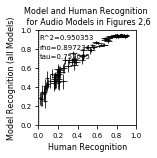

In [6]:
matplotlib.rcParams.update({'font.size': 7})

combined_human_means = []
combined_human_sem = []
combined_model_means = []
combined_model_sem = []

for model in combined_experiment_dict.keys():
    for layer in all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[model]['layers']:
        human_average = np.mean(combined_experiment_dict[model][layer])
        human_sem = np.std(combined_experiment_dict[model][layer])/np.sqrt(len(combined_experiment_dict[model][layer]))

        other_models_average = np.mean(all_other_nets_evals[model][layer])
        other_models_sem = np.std(all_other_nets_evals[model][layer])/np.sqrt(len(all_other_nets_evals[model][layer]))

        combined_human_means.append(human_average)
        combined_human_sem.append(human_sem)

        combined_model_means.append(other_models_average)
        combined_model_sem.append(other_models_sem)
    
plt.figure(figsize=(1.75,1.75))
plt.errorbar(combined_human_means, 
             combined_model_means,
             fmt='.',
             xerr=combined_human_sem,
             yerr=combined_model_sem,
             color='k',
             linewidth=0.75,
             markersize=2)
plt.plot([1/794,1/794],[0,1],':',color='grey', linewidth=0.75)
plt.plot([0,1],[1/793,1/793],':',color='grey', linewidth=0.75)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Human Recognition', fontsize=8)
plt.ylabel('Model Recognition (all Models)', fontsize=8)
plt.title('Model and Human Recognition \n for Audio Models in Figures 2,6', fontsize=8)

import scipy.stats
r_value, p_value = scipy.stats.pearsonr(combined_human_means, combined_model_means)
print(p_value)
plt.text(0.01,0.9,'R^2=%f'%r_value**2, fontsize=7)

r_value, p_value = scipy.stats.spearmanr(combined_human_means, combined_model_means)
print(p_value)
plt.text(0.01,0.8,'rho=%f'%r_value, fontsize=7)

r_value, p_value = scipy.stats.kendalltau(combined_human_means, combined_model_means)
print(p_value)
print(r_value)
plt.text(0.01,0.7,'tau=%f'%r_value, fontsize=7)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig('ScatterModelHumanAudioModels_update_size.pdf')

# Change back for the other plots in this notebook
matplotlib.rcParams.update({'font.size': 6})




# Group by the model type and show the human predictions

In [7]:
model_groupings = {'Generated: Standard':['cochresnet50'],
                   'Generated: waveform_adversaries':["cochresnet50_l2_1_robust_waveform", "cochresnet50_l2_p5_robust_waveform", "cochresnet50_linf_p002_robust_waveform",],
                   'Generated: cochleagram_adversaries':["cochresnet50_l2_1_robust_cochleagram", "cochresnet50_l2_p5_robust_cochleagram"],
                   'Generated: cochleagram_random_perturbations':["cochresnet50_l2_1_random_step_cochleagram"]}



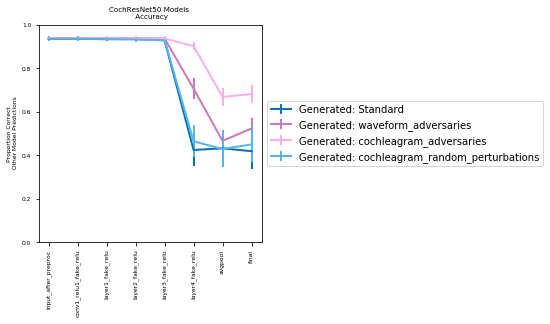

In [8]:
plt.figure(figsize=(4,4))
all_group_data = {}
all_group_data_human = {}

import seaborn as sns

color_idxs = [0,4,6,9]


for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    all_group_data_human[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        if (group_idx==0) and (met_mod_idx==0):
            metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
        else:
            # For this type of plot, the layers need to be *exactly* the same between the models. 
            assert metamer_model_layers == all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
            
        # TODO: how to combine across the experiments? Just taking the average across all participants, but maybe should not do that first? 
        # Not sure how to propagate the error here...
        all_group_data_human[metamer_group][metamer_model] = [np.mean(combined_experiment_dict[metamer_model][layer]) for layer in metamer_model_layers]
        
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct'][layer] for layer in metamer_model_layers]
                # How to propagate these errors? I guess we don't for this? So don't save them...
                bootstrap_sem = [eval_pckl['bootstrap_sem'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        collapse_data_human = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
                
    collapse_group_human_data = []
    for metamer_model in model_groupings[metamer_group]:
        collapse_data.append(all_group_data_human[metamer_group][metamer_model])
    if len(model_groupings[metamer_group])>1:
        average_data_from_group_human_data = np.mean(collapse_data)
    else: 
        average_data_from_group_human_data = np.squeeze(collapse_data)
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = sns.color_palette("colorblind")[color_idxs[group_idx]]
                 )
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('CochResNet50 Models \n Accuracy')
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n Other Model Predictions')
plt.xticks(range(len(metamer_model_layers)), metamer_model_layers, rotation=90)
            

plt.savefig('CochResNet50HumanRecModelGroupings.pdf')

